## Linear regression

Using a subset of the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) we will train a linear regression model in order to predict the release year of a song
in function of other information.

In [2]:
#sc.stop()

In [3]:
# Import findspark 
import findspark

# Or use this alternative
findspark.init()

In [4]:
# Import SparkSession
from pyspark.sql import SparkSession

# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Assignment 2_new") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext
#sc.stop()

### 1. Reading the data

In [5]:
#import os.path
#baseDir = os.path.join('data')
#inputPath = os.path.join('millionsong.txt')
#fileName = os.path.join(baseDir, inputPath)

numPartitions = 2
#rawData = sc.textFile(fileName, numPartitions)

numPartitions = 2
rawData = sc.textFile('C:\\Users\\sures\\Downloads\\MSD_new.txt', numPartitions)
#rawData = rawData.filter(lambda x: x is not u'')
#rawData = rawData.filter(lambda x: 'normal.' in x)
rawData = rawData.sample(False, .01, 12345)
#rawData= rawData.takeSample(False,10000)
#rawData = rawData.map(lambda x: x[0])
#raw_data = rawData.map(lambda x: (x[0:1]))


In [6]:
numPoints = rawData.count()
print(numPoints)
samplePoints = rawData.take(5)
print(samplePoints)

5271
['2000,37.22392,-88.45128,-1.54036,-15.89576,3.81949,-6.59919,-2.17960,15.62713,12.33636,18.21033,-2.74683,22.79603,21.78472,2733.56638,1929.49854,1421.14701,504.08695,609.38112,530.56538,499.16264,251.91846,256.86330,183.62562,281.71744,14.95908,-277.11925,537.38413,126.69542,74.56731,112.06345,-46.11079,-25.33577,-0.32702,-34.84208,39.53139,129.69655,-399.36208,410.20946,-137.43784,27.55392,-88.53630,-123.19672,-82.78610,-2.67767,-71.14324,44.63810,-256.48699,357.60349,-64.51858,29.08300,-100.48544,81.76492,-73.91439,-53.92166,19.48031,-79.24546,360.21283,528.18487,-89.05889,208.85243,-30.02055,-52.12754,15.06942,-156.18082,-93.46108,-115.32078,35.81618,-27.48383,-19.94318,21.84318,-264.55222,-373.48640,-291.95428,-25.88227,-18.29170,-9.16908,45.40815,-108.68055,-66.22533,-30.92552,-25.59803,-22.08026,97.96720,-1.16606,-18.21663,63.28837,139.77014,6.53754,278.35847,37.18096', '2000,46.31975,-7.70730,2.54303,-13.50434,-27.69327,-14.40325,-11.86570,-16.20503,17.19018,0.39350,0.335

#### The `LabeledPoint` class

In [7]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [8]:
def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.

    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    label_and_features = line.split(',')
    return LabeledPoint(label_and_features[0], label_and_features[1:13])

parsedSamplePoints = list(map(parsePoint, samplePoints))
firstPointFeatures = parsedSamplePoints[0].features
firstPointLabel = parsedSamplePoints[0].label
print('{}, {}'.format(firstPointFeatures, firstPointLabel))

d = len(firstPointFeatures)
print(d)

[37.22392,-88.45128,-1.54036,-15.89576,3.81949,-6.59919,-2.1796,15.62713,12.33636,18.21033,-2.74683,22.79603], 2000.0
12


#### Feature visualization

We visualize the raw features for 50 data points by generating a heatmap that shows each feature on a grey-scale and illustrates the variation of each feature across the 50 sampled data points.  The features are all between 0 and 1, with values closer to 1 represented via darker shades of grey.

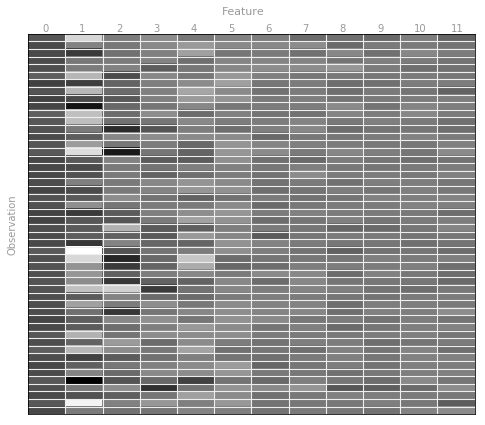

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

sampleMorePoints = rawData.take(50)
# You can uncomment the line below to see randomly selected features.  These will be randomly
# selected each time you run the cell.
#sampleMorePoints = rawData.takeSample(False, 50)

parsedSampleMorePoints = list(map(parsePoint, sampleMorePoints))
dataValues = list(map(lambda lp: lp.features.toArray(), parsedSampleMorePoints))

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False),
        ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot
fig, ax = preparePlot(np.arange(.5, 11, 1), np.arange(.5, 49, 1),
                      figsize=(8,7), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(dataValues, interpolation='nearest',
                   aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1),
                   np.repeat(-.75, 12),
                   [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11')
ax.set_ylabel('Observation')
plt.show()

#### Find the range

Let's examine the labels to find the range of song years.  To do this, first parse each element of the `rawData` RDD, and then find the smallest and largest labels.

In [10]:
parsedDataInit = rawData.map(lambda s: parsePoint(s))
onlyLabels = parsedDataInit.map(lambda p: p.label)
minYear = onlyLabels.min()
maxYear = onlyLabels.max()
print(maxYear, minYear)

2010.0 1929.0


#### Shift labels

Labels are years in the 1900s and 2000s.  In learning problems, it is often natural to shift labels such that they start from zero.  Starting with `parsedDataInit`, create a new RDD consisting of `LabeledPoint` objects in which the labels are shifted such that smallest label equals zero.

In [11]:
parsedData = parsedDataInit.map(lambda p: LabeledPoint(p.label-minYear, p.features))

# Should be a LabeledPoint
print(type(parsedData.take(1)[0]))
# View the first point
print('\n{0}'.format(parsedData.take(1)))

<class 'pyspark.mllib.regression.LabeledPoint'>

[LabeledPoint(71.0, [37.22392,-88.45128,-1.54036,-15.89576,3.81949,-6.59919,-2.1796,15.62713,12.33636,18.21033,-2.74683,22.79603])]


#### Shifting labels

We will look at the labels before and after shifting them.  Both scatter plots below visualize tuples storing i) a label value and ii) the number of training points with this label.  The first scatter plot uses the initial labels, while the second one uses the shifted labels.  Note that the two plots look the same except for the labels on the x-axis.

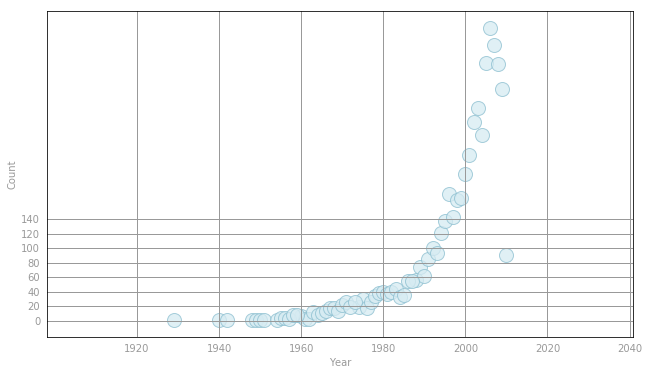

In [12]:
# get data for plot
oldData = (parsedDataInit
           .map(lambda lp: (lp.label, 1))
           .reduceByKey(lambda x, y: x + y)
           .collect())
x, y = zip(*oldData)

# generate layout and plot data
fig, ax = preparePlot(np.arange(1920, 2050, 20), np.arange(0, 150, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year'), ax.set_ylabel('Count')
plt.show()

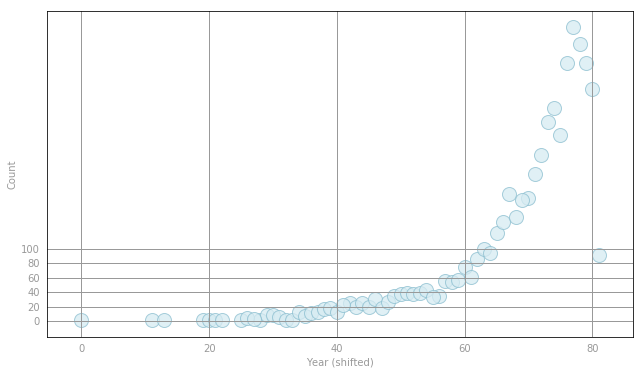

In [13]:
# get data for plot
newData = (parsedData
           .map(lambda lp: (lp.label, 1))
           .reduceByKey(lambda x, y: x + y)
           .collect())
x, y = zip(*newData)

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year (shifted)'), ax.set_ylabel('Count')
pass

#### Training, validation, and test sets

Our final task involves split it into training, validation and test sets. Use the`randomSplit` with the specified weights and seed to create RDDs storing each of these datasets. Next, cache each of these RDDs, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset and verify that the sum of their sizes equals the total number of data items.

In [14]:
weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights, seed=seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()
nTrain = parsedTrainData.count()
nVal = parsedValData.count()
nTest = parsedTestData.count()

print('{} {} {} {}'.format(nTrain, nVal, nTest, nTrain + nVal + nTest))
print(parsedData.count())

4153 535 583 5271
5271


### 2. Create and evaluate a baseline model

#### Average label

A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value.  Compute this value, which is the average (shifted) song year for the training set.

In [15]:
averageTrainYear = (parsedTrainData
                    .map(lambda p: p.label)
                    .mean())
print(averageTrainYear)

69.5868047194799


#### Root mean squared error

We naturally would like to see how well this naive baseline performs.  We will use root mean squared error (RMSE) for evaluation purposes.  Implement a function to compute RMSE given an RDD of (label, prediction) tuples, and test out this function on an example.

In [16]:
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    return (label - prediction) ** 2

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return np.sqrt(labelsAndPreds.map(lambda p: squaredError(*p)).mean())

labelsAndPreds = sc.parallelize([(3., 1.), (1., 2.), (2., 2.)])
# RMSE = sqrt[((3-1)^2 + (1-2)^2 + (2-2)^2) / 3] = 1.291
exampleRMSE = calcRMSE(labelsAndPreds)
print(exampleRMSE)

1.2909944487358056


#### Training, validation and test RMSE

Now let's calculate the training, validation and test RMSE of our baseline model. To do this, first create RDDs of (label, prediction) tuples for each dataset, and then call calcRMSE. Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of number of years).

In [17]:
labelsAndPredsTrain = parsedTrainData.map(lambda p: (p.label, averageTrainYear))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = parsedValData.map(lambda p: (p.label, averageTrainYear))
rmseValBase = calcRMSE(labelsAndPredsVal)

labelsAndPredsTest = parsedTestData.map(lambda p: (p.label, averageTrainYear))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))
print('Baseline Test RMSE = {0:.3f}'.format(rmseTestBase))

Baseline Train RMSE = 10.584
Baseline Validation RMSE = 10.981
Baseline Test RMSE = 10.275


#### Predicted vs. actual

We will visualize predictions on the validation dataset. The scatter plots below visualize tuples storing i) the predicted value and ii) true label.  The first scatter plot represents the ideal situation where the predicted value exactly equals the true label, while the second plot uses the baseline predictor (i.e., `averageTrainYear`) for all predicted values.  Further note that the points in the scatter plots are color-coded, ranging from light yellow when the true and predicted values are equal to bright red when they drastically differ.

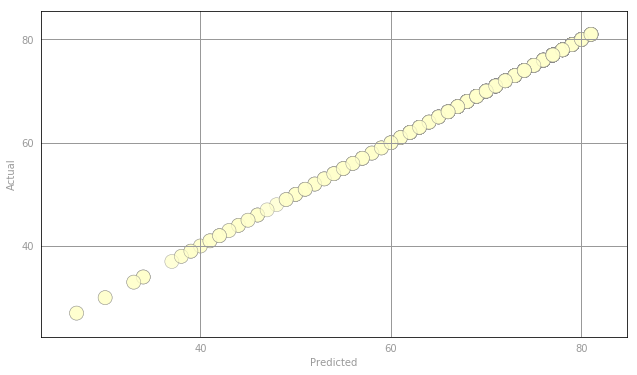

In [18]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda lp: squaredError(*lp))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
pass

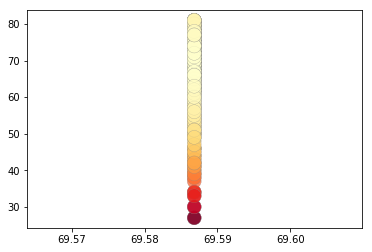

In [19]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: averageTrainYear)
                         .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, averageTrainYear))
                   .map(lambda lp: squaredError(*lp))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

#fig, ax = preparePlot(np.arange(76.0, 76.5, 0.5), np.arange(0, 100, 20))
#fig, ax = preparePlot(np.arange(0, 100, 20), np.arange(0, 100, 20))
#ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
#ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
plt.show()

### 3. Train via gradient descent and evaluate a linear regression model

#### Gradient summand

Now let's see if we can do better via linear regression, training a model via gradient descent (we'll omit the intercept for now). Recall that the gradient descent update for linear regression is: $$ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.$$ where $ \scriptsize i $ is the iteration number of the gradient descent algorithm, and $ \scriptsize j $ identifies the observation.

First, implement a function that computes the summand for this update, i.e., the summand equals $ \scriptsize (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \, ,$ and test out this function on two examples.  Use the `DenseVector` [dot](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector.dot) method.

In [20]:
from pyspark.mllib.linalg import DenseVector

In [21]:
def gradientSummand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    return (weights.dot(DenseVector(lp.features)) - lp.label) * lp.features

exampleW = DenseVector([1, 1, 1])
exampleLP = LabeledPoint(2.0, [3, 1, 4])
# gradientSummand = (dot([1 1 1], [3 1 4]) - 2) * [3 1 4] = (8 - 2) * [3 1 4] = [18 6 24]
summandOne = gradientSummand(exampleW, exampleLP)
print(summandOne)

exampleW = DenseVector([.24, 1.2, -1.4])
exampleLP = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summandTwo = gradientSummand(exampleW, exampleLP)
print(summandTwo)

[18.0,6.0,24.0]
[1.7304000000000002,-5.191200000000001,-2.5956000000000006]


#### Use weights to make predictions

Next, implement a `getLabeledPredictions` function that takes in weights and an observation's `LabeledPoint` and returns a (label, prediction) tuple.  Note that we can predict by computing the dot product between weights and an observation's features.

In [22]:
def getLabeledPrediction(weights, observation):
    """Calculates predictions and returns a (label, prediction) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (label, prediction) tuple.
    """
    return (observation.label, weights.dot(DenseVector(observation.features)))

weights = np.array([1.0, 1.5])
predictionExample = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                    LabeledPoint(1.5, np.array([.5, .5]))])
labelsAndPredsExample = predictionExample.map(lambda lp: getLabeledPrediction(weights, lp))
print(labelsAndPredsExample.collect())

[(2.0, 1.75), (1.5, 1.25)]


#### Gradient descent

Next, implement a gradient descent function for linear regression and test out this function on an example.

In [23]:
def linregGradientDescent(trainData, numIters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        numIters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    alpha = 1.0
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration,
        # so the predictions will have large errors to start.
        labelsAndPredsTrain = trainData.map(lambda p: getLabeledPrediction(w, p))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = sum([DenseVector(gradientSummand(w, lp)) for lp in trainData.collect()])

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient
    return w, errorTrain

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc
               .parallelize(parsedTrainData.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print(exampleData.take(2))
exampleNumIters = 5
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters)
print(exampleWeights)

[LabeledPoint(71.0, [37.22392,-88.45128,-1.54036]), LabeledPoint(71.0, [46.31975,-7.7073,2.54303])]
[ 5.82353669e+15 -3.95804252e+15  2.08610952e+15]


#### Train the model

Now let's train a linear regression model on all of our training data and evaluate its accuracy on the validation set.  Note that the test set will not be used here.  If we evaluated the model on the test set, we would bias our final results.

We've already done much of the required work: we computed the number of features, we created the training and validation datasets and computed their sizes, and we wrote a function to compute RMSE.

In [24]:
numIters = 50
weightsLR0, errorTrainLR0 = linregGradientDescent(parsedTrainData, numIters)

labelsAndPreds = parsedValData.map(lambda p: getLabeledPrediction(weightsLR0, p))
rmseValLR0 = calcRMSE(labelsAndPreds)

print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase,
                                                                       rmseValLR0))

C:\spark-2.4.3\python\pyspark\statcounter.py:83: RuntimeWarning: overflow encountered in double_scalars
  self.m2 += other.m2 + (delta * delta * self.n * other.n) / (self.n + other.n)


Validation RMSE:
	Baseline = 10.981
	LR0 = 4376497350749410999867316111212981540165180369312270163280062640341209191432032849236290448381338559771792065283982741176240291134831935356928.000


#### Visualization of training error

We will look at the log of the training error as a function of iteration. The first scatter plot visualizes the logarithm of the training error for all 50 iterations.  The second plot shows the training error itself, focusing on the final 44 iterations.

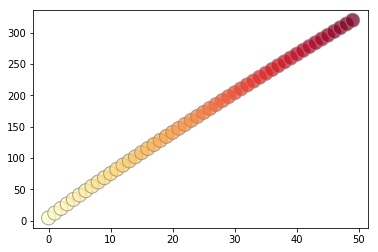

In [25]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(errorTrainLR0))))[:,0:3]

#fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(2, 5, 1))
#ax.set_ylim(2, 5)
plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
#plt.plot(range(0, numIters), np.log(errorTrainLR0))

#ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
plt.show()

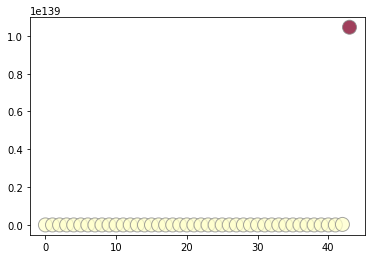

In [26]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[6:])))[:,0:3]

#fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 22, 1))
#ax.set_ylim(16.8, 21.2)
plt.scatter(range(0, numIters-6), errorTrainLR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
#plt.plot(range(0, numIters-6), errorTrainLR0[6:])
#ax.set_xticklabels(map(str, range(6, 66, 10)))
#ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
plt.show()

In [27]:
sc.stop()